# Precision Aware Update Testing

This notebook tests and visualizes the relative error of the precision-aware update algorithm compared to the default approach.

In [8]:
import sys
sys.path.append('..')

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from flax import nnx
from ueaj.utils.tensorutil import (
    precision_aware_update, sq_norm, stochastic_rounding_update, quadratic_update, quadratic_update_2
)

In [9]:
def param_error(params: jax.Array, method_params: jax.Array, update: jax.Array):
	"""Compute statistics of (method - original) / update."""
	# Cast to float32 to avoid type promotion errors
	params_f32 = params.astype(jnp.float32)
	method_f32 = method_params.astype(jnp.float32)
	update_f32 = update.astype(jnp.float32)

	# Compute relative error
	relative_error = (method_f32 - params_f32) / (update_f32 + 1e-12)  # Add small epsilon to avoid division by zero

	# Compute statistics
	mean = relative_error.mean()
	median = jnp.median(relative_error)
	q1 = jnp.percentile(relative_error, 25)
	q3 = jnp.percentile(relative_error, 75)

	return mean, median, q1, q3

In [10]:
# Initialize test data (will be used across all tests)
rng_key = jax.random.PRNGKey(0)
# Keep these for reuse across different dtype tests
base_params = jax.random.normal(rng_key, (1024, 1024), jnp.float32)
base_update = jax.random.normal(rng_key, (1024, 1024), jnp.float32)

In [15]:
# Function to run tests for a specific dtype
def run_precision_test(params_dtype=jnp.float8_e4m3fn, update=None, num_tests=33):
    """Run precision aware update tests for a specific dtype."""
    # Use provided update or create new one
    if update is None:
        rng_key = jax.random.PRNGKey(0)
        params = jax.random.normal(rng_key, (1024, 1024), jnp.float32).astype(params_dtype)
        update = jax.random.normal(rng_key, (1024, 1024), jnp.float32)
    else:
        # Use base params with specified dtype
        params = base_params.astype(params_dtype)
    
    # Initialize results dictionary
    results = {
        'exponents': [],
        'lrs': [],
        'methods': {
            'iterative': {'norm_ratio': [], 'mean': [], 'median': [], 'q1': [], 'q3': []},
            'default': {'norm_ratio': [], 'mean': [], 'median': [], 'q1': [], 'q3': []},
            'stochastic': {'norm_ratio': [], 'mean': [], 'median': [], 'q1': [], 'q3': []},
            'quadratic': {'norm_ratio': [], 'mean': [], 'median': [], 'q1': [], 'q3': []},
            'quadratic2': {'norm_ratio': [], 'mean': [], 'median': [], 'q1': [], 'q3': []}
        }
    }
    
    for i in range(num_tests):
        target_lr = 2**(-i)
        target_params = params.astype(jnp.float32) + target_lr * update
        
        # Different update methods
        methods_params = {
            'iterative': precision_aware_update(params, update, target_lr),
            'default': ((params.astype(jnp.float32) + target_lr*update).astype(params_dtype), 
                       sq_norm((params.astype(jnp.float32) + target_lr*update).astype(params_dtype) - params), 
                       None),
            'stochastic': (*stochastic_rounding_update(params, update, target_lr, rngs=nnx.Rngs(i)), None),
            'quadratic': quadratic_update(params, update, target_lr),
            'quadratic2': quadratic_update_2(params, update, target_lr)
        }
        
        # Extract target norm from iterative method
        target_norm = methods_params['iterative'][2]
        
        # Store general info
        results['exponents'].append(-i)
        results['lrs'].append(target_lr)
        
        # Process each method
        for method_name, (method_params, method_norm, _) in methods_params.items():
            # Compute norm ratio
            norm_ratio = method_norm / target_norm
            results['methods'][method_name]['norm_ratio'].append(float(norm_ratio))
            
            # Compute parameter statistics
            mean, median, q1, q3 = param_error(params, method_params, update*target_lr)
            results['methods'][method_name]['mean'].append(float(mean))
            results['methods'][method_name]['median'].append(float(median))
            results['methods'][method_name]['q1'].append(float(q1))
            results['methods'][method_name]['q3'].append(float(q3))
        
        # Print progress
        if i % 5 == 0:  # Print every 5th for brevity
            print(f"LR = 2^{-i} ({target_lr:.3e}), dtype = {params_dtype}")
            for method in ['iterative', 'default', 'stochastic', 'quadratic', 'quadratic2']:
                m = results['methods'][method]
                print(f"  {method}: norm_ratio={m['norm_ratio'][-1]:.3f}, "
                      f"median={m['median'][-1]:.3e}, mean={m['mean'][-1]:.3e}")
    
    return results, params, update

# Run the test for float8
print("Running precision aware update tests...")
results, params, update = run_precision_test(jnp.float8_e4m3fn, update=base_update)

Running precision aware update tests...
LR = 2^0 (1.000e+00), dtype = <class 'jax.numpy.float8_e4m3fn'>
  iterative: norm_ratio=0.999, median=9.988e-01, mean=9.983e-01
  default: norm_ratio=0.999, median=9.990e-01, mean=9.987e-01
  stochastic: norm_ratio=0.999, median=9.990e-01, mean=9.987e-01
  quadratic: norm_ratio=0.999, median=9.989e-01, mean=9.985e-01
  quadratic2: norm_ratio=0.999, median=9.990e-01, mean=9.987e-01
LR = 2^-5 (3.125e-02), dtype = <class 'jax.numpy.float8_e4m3fn'>
  iterative: norm_ratio=0.999, median=5.599e+00, mean=5.538e+00
  default: norm_ratio=0.000, median=0.000e+00, mean=0.000e+00
  stochastic: norm_ratio=0.003, median=0.000e+00, mean=5.099e-02
  quadratic: norm_ratio=1.020, median=5.661e+00, mean=5.596e+00
  quadratic2: norm_ratio=1.013, median=5.639e+00, mean=5.575e+00
LR = 2^-10 (9.766e-04), dtype = <class 'jax.numpy.float8_e4m3fn'>
  iterative: norm_ratio=0.997, median=-0.000e+00, mean=1.414e+01
  default: norm_ratio=0.000, median=0.000e+00, mean=0.000e+0

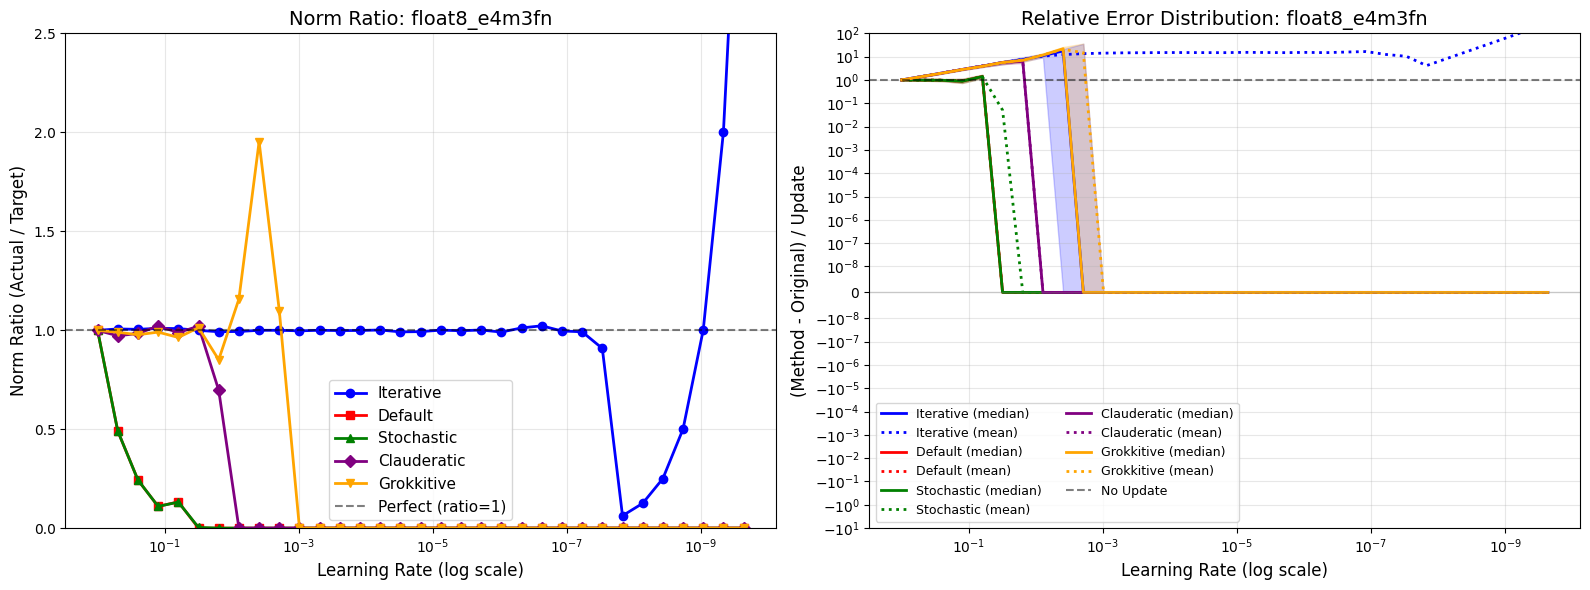

In [14]:
# Plotting function
def plot_results(results, dtype_name="float8_e4m3fn"):
    """Plot the results from precision tests."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Colors and styles for each method
    styles = {
        'iterative': {'color': 'blue', 'marker': 'o', 'label': 'Iterative'},
        'default': {'color': 'red', 'marker': 's', 'label': 'Default'},
        'stochastic': {'color': 'green', 'marker': '^', 'label': 'Stochastic'},
        'quadratic': {'color': 'purple', 'marker': 'D', 'label': 'Clauderatic'},
        'quadratic2': {'color': 'orange', 'marker': 'v', 'label': 'Grokkitive'}
    }
    
    # Extract data
    lrs = np.array(results['lrs'])
    
    # Plot 1: Norm ratios
    for method, style in styles.items():
        if method in results['methods']:
            data = results['methods'][method]
            ax1.semilogx(lrs, data['norm_ratio'], 
                         color=style['color'], marker=style['marker'], linestyle='-',
                         label=style['label'], markersize=6, linewidth=2)
    
    ax1.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Perfect (ratio=1)')
    ax1.set_xlabel('Learning Rate (log scale)', fontsize=12)
    ax1.set_ylabel('Norm Ratio (Actual / Target)', fontsize=12)
    ax1.set_title(f'Norm Ratio: {dtype_name}', fontsize=14)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 2.5)
    ax1.invert_xaxis()
    
    # Plot 2: Parameter error distribution
    for method, style in styles.items():
        if method in results['methods']:
            data = results['methods'][method]
            median = np.array(data['median'])
            mean = np.array(data['mean'])
            q1 = np.array(data['q1'])
            q3 = np.array(data['q3'])
            
            # Plot median (solid) and mean (dotted)
            ax2.semilogx(lrs, median, color=style['color'], linestyle='-',
                         label=f"{style['label']} (median)", linewidth=2)
            ax2.semilogx(lrs, mean, color=style['color'], linestyle=':',
                         label=f"{style['label']} (mean)", linewidth=2)
            
            # Add quartile ranges
            ax2.fill_between(lrs, q1, q3, color=style['color'], alpha=0.2)
    
    ax2.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='No Update')
    ax2.axhline(y=0.0, color='gray', linestyle='-', alpha=0.3, linewidth=1)
    ax2.set_xlabel('Learning Rate (log scale)', fontsize=12)
    ax2.set_ylabel('(Method - Original) / Update', fontsize=12)
    ax2.set_title(f'Relative Error Distribution: {dtype_name}', fontsize=14)
    ax2.legend(fontsize=9, ncol=2)
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('symlog', linthresh=1e-8)
    ax2.set_ylim(-1e1, 1e2)
    ax2.invert_xaxis()
    
    plt.tight_layout()
    plt.show()

# Plot the results
plot_results(results)


Testing float8_e4m3fn
LR = 2^0 (1.000e+00), dtype = <class 'jax.numpy.float8_e4m3fn'>
  iterative: norm_ratio=0.999, median=9.988e-01, mean=9.983e-01
  default: norm_ratio=0.999, median=9.990e-01, mean=9.987e-01
  stochastic: norm_ratio=0.999, median=9.990e-01, mean=9.987e-01
  quadratic: norm_ratio=0.999, median=9.989e-01, mean=9.985e-01
  quadratic2: norm_ratio=0.999, median=9.990e-01, mean=9.987e-01
LR = 2^-5 (3.125e-02), dtype = <class 'jax.numpy.float8_e4m3fn'>
  iterative: norm_ratio=0.999, median=5.599e+00, mean=5.538e+00
  default: norm_ratio=0.000, median=0.000e+00, mean=0.000e+00
  stochastic: norm_ratio=0.003, median=0.000e+00, mean=5.099e-02
  quadratic: norm_ratio=1.020, median=5.661e+00, mean=5.596e+00
  quadratic2: norm_ratio=1.013, median=5.639e+00, mean=5.575e+00
LR = 2^-10 (9.766e-04), dtype = <class 'jax.numpy.float8_e4m3fn'>
  iterative: norm_ratio=0.997, median=-0.000e+00, mean=1.414e+01
  default: norm_ratio=0.000, median=0.000e+00, mean=0.000e+00
  stochastic: n

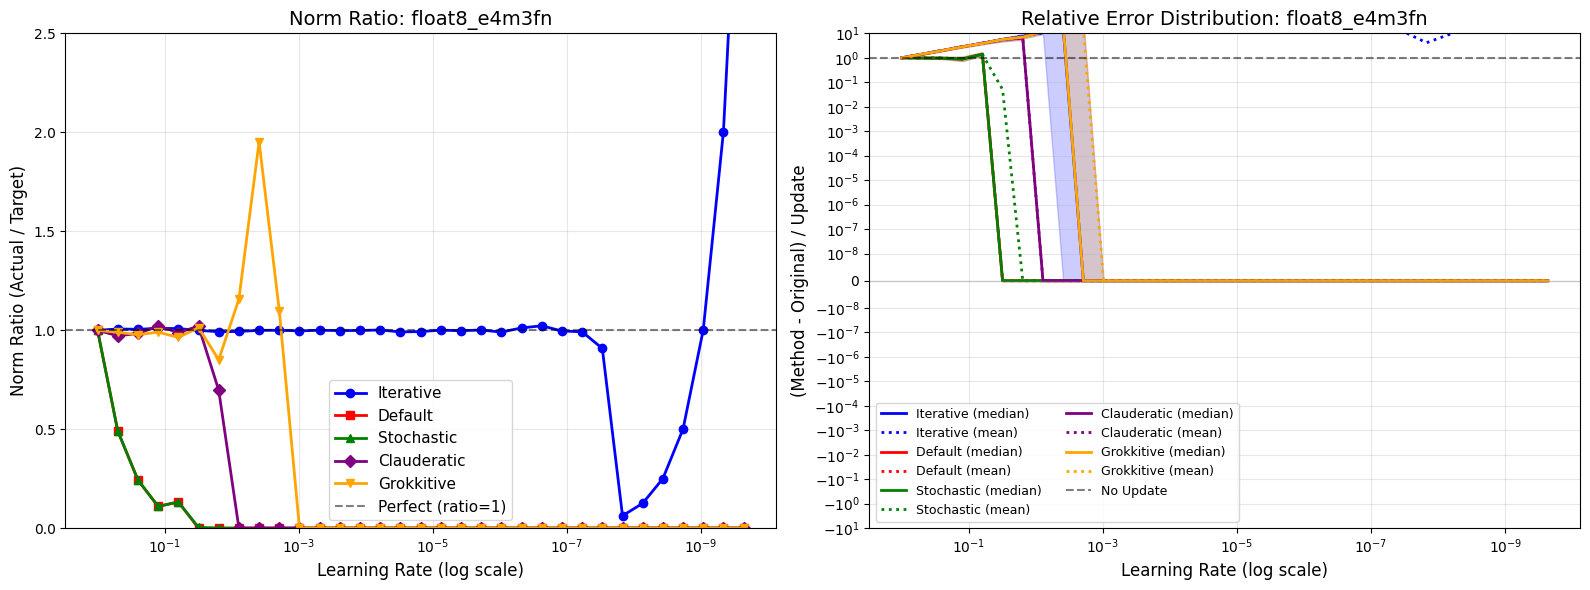


Testing float16
LR = 2^0 (1.000e+00), dtype = <class 'jax.numpy.float16'>
  iterative: norm_ratio=0.992, median=9.961e-01, mean=9.961e-01
  default: norm_ratio=1.000, median=1.000e+00, mean=1.000e+00
  stochastic: norm_ratio=1.000, median=1.000e+00, mean=1.000e+00
  quadratic: norm_ratio=1.000, median=1.000e+00, mean=1.000e+00
  quadratic2: norm_ratio=1.000, median=1.000e+00, mean=1.000e+00
LR = 2^-5 (3.125e-02), dtype = <class 'jax.numpy.float16'>
  iterative: norm_ratio=1.000, median=5.656e+00, mean=5.656e+00
  default: norm_ratio=0.031, median=9.999e-01, mean=9.999e-01
  stochastic: norm_ratio=0.031, median=9.999e-01, mean=1.000e+00
  quadratic: norm_ratio=1.000, median=5.657e+00, mean=5.657e+00
  quadratic2: norm_ratio=1.000, median=5.657e+00, mean=5.657e+00
LR = 2^-10 (9.766e-04), dtype = <class 'jax.numpy.float16'>
  iterative: norm_ratio=1.000, median=3.200e+01, mean=3.200e+01
  default: norm_ratio=0.001, median=9.428e-01, mean=9.617e-01
  stochastic: norm_ratio=0.001, median=9

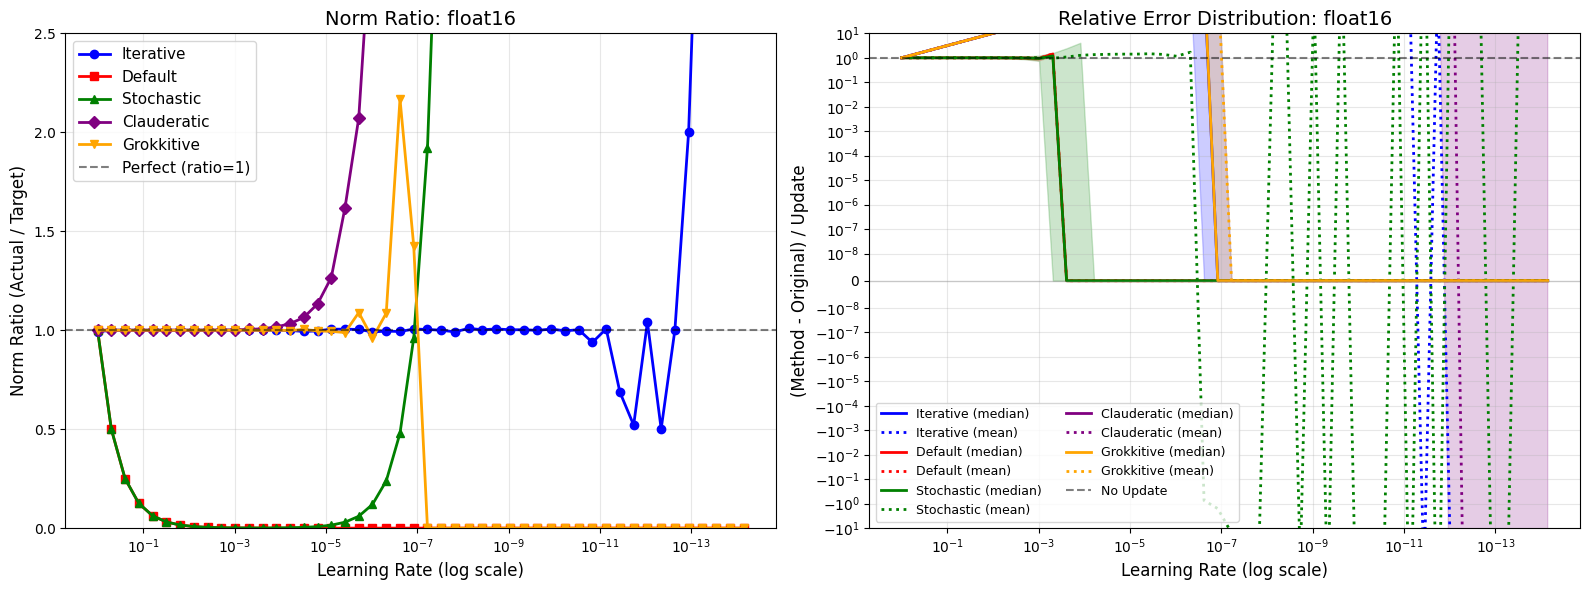


Testing bfloat16
LR = 2^0 (1.000e+00), dtype = <class 'jax.numpy.bfloat16'>
  iterative: norm_ratio=0.996, median=9.988e-01, mean=9.978e-01
  default: norm_ratio=1.000, median=1.000e+00, mean=1.000e+00
  stochastic: norm_ratio=1.000, median=1.000e+00, mean=1.000e+00
  quadratic: norm_ratio=1.000, median=1.000e+00, mean=1.000e+00
  quadratic2: norm_ratio=1.000, median=1.000e+00, mean=1.000e+00
LR = 2^-5 (3.125e-02), dtype = <class 'jax.numpy.bfloat16'>
  iterative: norm_ratio=1.000, median=5.655e+00, mean=5.656e+00
  default: norm_ratio=0.031, median=9.921e-01, mean=9.943e-01
  stochastic: norm_ratio=0.032, median=9.947e-01, mean=1.000e+00
  quadratic: norm_ratio=0.999, median=5.655e+00, mean=5.655e+00
  quadratic2: norm_ratio=1.000, median=5.656e+00, mean=5.656e+00
LR = 2^-10 (9.766e-04), dtype = <class 'jax.numpy.bfloat16'>
  iterative: norm_ratio=0.992, median=3.175e+01, mean=3.182e+01
  default: norm_ratio=0.000, median=0.000e+00, mean=0.000e+00
  stochastic: norm_ratio=0.009, medi

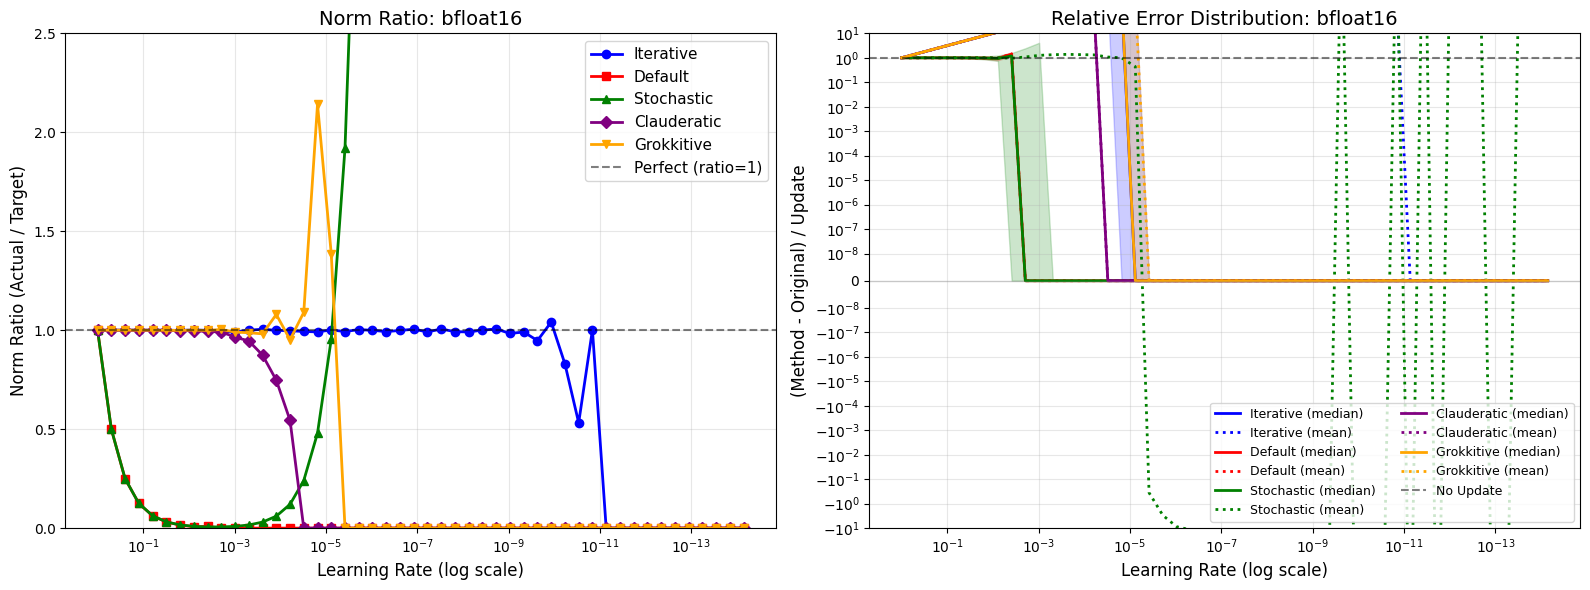

In [13]:
# Compare different dtypes
dtypes_to_test = {
    'float8_e4m3fn': (jnp.float8_e4m3fn, 33),
    'float16': (jnp.float16, 48),
    'bfloat16': (jnp.bfloat16, 48),
}

# Run tests for each dtype (using the same update vector for fair comparison)
all_results = {}
for dtype_name, (dtype, num_tests) in dtypes_to_test.items():
    print(f"\n{'='*60}")
    print(f"Testing {dtype_name}")
    print('='*60)
    # Use the same update vector across all dtypes for fair comparison
    results_dtype, _, _ = run_precision_test(dtype, update=update, num_tests=num_tests)  # Fewer tests for speed
    all_results[dtype_name] = results_dtype
    
    # Plot results for this dtype
    plot_results(results_dtype, dtype_name)